### Basisversion

In [ ]:
import numpy as np
import pandas as pd
import time
import os
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore")

# =============================================================================
# Augmentierungsfunktionen
# =============================================================================

def perform_clustering(X_sub, max_clusters=4):
    cols = [col for col in X_sub.columns if col not in ["Verletzungsstatus", "Geschlecht_weiblich"]]
    X_num = X_sub[cols]
    # Absolute Korrelationsmatrix, NA-Werte mit 0 auffüllen und Symmetrie erzwingen
    corr = X_num.corr().abs().fillna(0)
    corr = (corr + corr.T) / 2
    dist = np.clip(1 - corr, a_min=0, a_max=None)
    dists = squareform(dist.values)
    Z = linkage(dists, method='ward')
    cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')
    clusters = {}
    for col, label in zip(cols, cluster_labels):
        clusters.setdefault(label, []).append(col)
    return clusters

def augment_subgroup(X_sub, clusters, p_augment=0.7):
    augmented_rows = []
    cluster_params = {}
    for cl_id, cols in clusters.items():
        cluster_data = X_sub[cols]
        mu = cluster_data.mean().values
        if len(cols) == 1:
            cov = np.cov(cluster_data.values.flatten(), ddof=0)
            cov = np.atleast_2d(cov)
        else:
            cov = np.cov(cluster_data.values, rowvar=False)
        cluster_params[cl_id] = (mu, cov, cols)
    for idx, row in X_sub.iterrows():
        new_row = row.copy()
        for cl_id, (mu, cov, cols) in cluster_params.items():
            if np.random.rand() < p_augment:
                new_values = np.random.multivariate_normal(mu, cov)
                for col, val in zip(cols, new_values):
                    new_row[col] = val
        augmented_rows.append(new_row)
    augmented_df = pd.DataFrame(augmented_rows)
    # Binäre Spalten unverändert übernehmen
    for col in ["Geschlecht_weiblich", "Verletzungsstatus"]:
        if col in augmented_df.columns:
            augmented_df[col] = augmented_df[col].astype(int)
    return augmented_df

def process_group_cluster(group_df, num_new_samples, max_clusters, p_augment):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment)
        aug_list.append(aug)
    return pd.concat(aug_list, axis=0)

def augment_training_data_cluster(X_train, y_train, num_new_samples=1, max_clusters=4, p_augment=0.7, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = [group_df for _, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])]
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster)(group_df, num_new_samples, max_clusters, p_augment)
        for group_df in groups
    )
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def add_noise_to_data(df, noise_factor=0.1):
    df_noisy = df.copy()
    numeric_cols = [col for col in df_noisy.select_dtypes(include=['float64', 'int64']).columns 
                    if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    for col in numeric_cols:
        std = df_noisy[col].std()
        noise = np.random.normal(0, std * noise_factor, size=df_noisy.shape[0])
        df_noisy[col] += noise
    return df_noisy

def add_noise_to_group(df_group, noise_factor=0.1):
    return add_noise_to_data(df_group, noise_factor=noise_factor)

def process_group_cluster_noise(group_df, num_new_samples, max_clusters, p_augment, noise_factor):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment)
        aug_list.append(aug)
    aug_group = pd.concat(aug_list, axis=0).reset_index(drop=True)
    n = len(aug_group)
    half = n // 2
    global_noise = add_noise_to_data(aug_group.copy(), noise_factor=noise_factor)
    group_noise = add_noise_to_group(aug_group.copy(), noise_factor=noise_factor)
    aug_noisy = pd.concat([global_noise.iloc[:half], group_noise.iloc[:half]], axis=0)
    return aug_noisy

def augment_training_data_cluster_noise(X_train, y_train, num_new_samples=1, max_clusters=4, 
                                        p_augment=0.7, noise_factor=0.1, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = [group_df for _, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])]
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster_noise)(group_df, num_new_samples, max_clusters, p_augment, noise_factor)
        for group_df in groups
    )
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def process_group_means(group_df, group_new_samples):
    """Erzeugt neue Samples durch Mittelwertbildung aus zwei zufällig ausgewählten Samples.
       Dabei werden die binären Spalten 'Verletzungsstatus' und 'Geschlecht_weiblich' direkt übernommen."""
    group_df = group_df.reset_index(drop=True)
    new_group_samples = []
    if len(group_df) < 2:
        return None
    numeric_cols = [col for col in group_df.columns if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    pairs = np.random.choice(len(group_df), (group_new_samples, 2), replace=True)
    for i in range(group_new_samples):
        sample1 = group_df.iloc[pairs[i, 0]]
        sample2 = group_df.iloc[pairs[i, 1]]
        mean_sample = sample1.copy()
        for col in numeric_cols:
            mean_sample[col] = (sample1[col] + sample2[col]) / 2
        mean_sample["Verletzungsstatus"] = sample1["Verletzungsstatus"]
        mean_sample["Geschlecht_weiblich"] = sample1["Geschlecht_weiblich"]
        new_group_samples.append(mean_sample)
    if new_group_samples:
        return pd.DataFrame(new_group_samples)
    return None

def augment_data_by_group_means(X_train, y_train, augmentation_factor=2, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])
    total_original_samples = len(df_train)
    total_new_samples = int(total_original_samples * (augmentation_factor - 1))
    group_sizes = groups.size()
    group_proportions = group_sizes / total_original_samples
    tasks = []
    for (injury_status, is_female), group_df in groups:
        group_new_samples = int(total_new_samples * group_proportions[(injury_status, is_female)])
        tasks.append((group_df, group_new_samples))
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_means)(group_df, group_new_samples)
        for group_df, group_new_samples in tasks
    )
    augmented_groups = [group for group in augmented_groups if group is not None]
    augmented_df = pd.concat([df_train] + augmented_groups, ignore_index=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def augment_training_data_combined(X_train, y_train, target_size=1000, verbose=True, n_jobs=-1,
                                   max_clusters=4, noise_factor=0.1):
    """
    Führt alle drei Augmentierungsmethoden (Cluster-basiert, Cluster+Rauschen, Mittelwert-basiert)
    parallel aus und kombiniert die Ergebnisse, um den Trainingsdatensatz auf die gewünschte Zielgröße zu bringen.
    """
    start_time = time.time()
    N = len(X_train)
    additional_needed = max(target_size - N, 0)
    per_method_needed = additional_needed // 3
    num_new_samples = max(per_method_needed // N, 1)
    augmentation_factor = 1 + (per_method_needed / N)
    if verbose:
        print(f"Starting combined augmentation to reach target size: {target_size}")
        print(f"Original dataset size: {N}")
        print(f"Samples needed per method: {per_method_needed}")
    funcs_and_params = [
        (augment_training_data_cluster, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
        (augment_training_data_cluster_noise, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
        (augment_data_by_group_means, {"augmentation_factor": augmentation_factor, "n_jobs": n_jobs})
    ]
    results = Parallel(n_jobs=min(3, n_jobs))(
        delayed(func)(X_train, y_train, **params) for func, params in funcs_and_params
    )
    X_aug_cluster, y_aug_cluster = results[0]
    X_aug_cluster_noise, y_aug_cluster_noise = results[1]
    X_aug_group_means, y_aug_group_means = results[2]
    def subsample(X_aug, y_aug, required):
        if len(X_aug) > required:
            idx = np.random.choice(len(X_aug), required, replace=False)
            return X_aug.iloc[idx].reset_index(drop=True), y_aug.iloc[idx].reset_index(drop=True)
        else:
            return X_aug, y_aug
    X_aug_cluster, y_aug_cluster = subsample(X_aug_cluster, y_aug_cluster, per_method_needed)
    X_aug_cluster_noise, y_aug_cluster_noise = subsample(X_aug_cluster_noise, y_aug_cluster_noise, per_method_needed)
    X_aug_group_means, y_aug_group_means = subsample(X_aug_group_means, y_aug_group_means, per_method_needed)
    X_aug_combined = pd.concat([X_aug_cluster, X_aug_cluster_noise, X_aug_group_means], axis=0).reset_index(drop=True)
    y_aug_combined = pd.concat([y_aug_cluster, y_aug_cluster_noise, y_aug_group_means], axis=0).reset_index(drop=True)
    X_total = pd.concat([X_train.reset_index(drop=True), X_aug_combined], axis=0).reset_index(drop=True)
    y_total = pd.concat([y_train.reset_index(drop=True), y_aug_combined], axis=0).reset_index(drop=True)
    if len(X_total) > target_size:
        idx = np.random.choice(len(X_total), target_size, replace=False)
        X_total = X_total.iloc[idx].reset_index(drop=True)
        y_total = y_total.iloc[idx].reset_index(drop=True)
    elapsed_time = time.time() - start_time
    if verbose:
        print(f"Augmentation completed. Final dataset size: {len(X_total)}")
        print(f"Augmentation took {elapsed_time:.2f} seconds")
    return X_total, y_total

# =============================================================================
# Modellaufbau und Training
# =============================================================================

def create_model(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# =============================================================================
# CV-Pipeline
# =============================================================================


def run_cv_pipeline(data_path, target_column="Verletzungsstatus", cv_splits=5, cv_repeats=10,
                    target_augmentation_multiplier=11, verbose=True, n_jobs=-1):
    """
    Liest die Daten ein, führt eine stratified Cross-Validation durch, 
    augmentiert in jedem Fold den Trainingsdatensatz und trainiert anschließend ein Modell.
    Aggregiert die Ergebnisse (Mittelwert und Standardabweichung) und gibt diese zurück.
    """
    try:
        df = pd.read_excel(data_path)
    except Exception as e:
        print(f"Error loading data: {e}")
        return None
    if target_column not in df.columns:
        print(f"Target column '{target_column}' not found in data")
        return None
    y = df[target_column]
    X = df.drop(columns=[target_column])
    if verbose:
        print(f"Data loaded: {len(df)} samples, {X.shape[1]} features")
        print(f"Class distribution: {y.value_counts().to_dict()}")
    cv = RepeatedStratifiedKFold(n_splits=cv_splits, n_repeats=cv_repeats, random_state=42)
    metrics_results = []
    for train_index, test_index in cv.split(X, y):
        if verbose:
            print("\n--- New Fold ---")
        X_train, y_train = X.iloc[train_index].copy(), y.iloc[train_index].copy()
        X_test, y_test = X.iloc[test_index].copy(), y.iloc[test_index].copy()
        target_size = int(len(X_train) * target_augmentation_multiplier)
        # Augmentation durchführen
        X_train_aug, y_train_aug = augment_training_data_combined(X_train, y_train,
                                                                   target_size=target_size,
                                                                   verbose=verbose,
                                                                   n_jobs=n_jobs)
        # Skalierung
        scaler = MinMaxScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_aug), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
        # Modell erstellen und trainieren
        model = create_model(input_dim=X_train_scaled.shape[1])
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = model.fit(X_train_scaled, y_train_aug,
                            validation_split=0.2,
                            epochs=100,
                            batch_size=16,
                            callbacks=[early_stop],
                            verbose=0)
        # Evaluation auf Trainingsdaten (Train Accuracy)
        y_train_pred_prob = model.predict(X_train_scaled)
        y_train_pred = (y_train_pred_prob > 0.5).astype(int).flatten()
        train_acc = accuracy_score(y_train_aug, y_train_pred)
        # Evaluation auf Testdaten (Test Accuracy und weitere Metriken)
        y_pred_prob = model.predict(X_test_scaled)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
        test_acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        try:
            roc = roc_auc_score(y_test, y_pred_prob)
        except Exception:
            roc = None
        metrics_results.append({
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'f1_score': f1,
            'precision': prec,
            'recall': rec,
            'roc_auc': roc
        })
    results_df = pd.DataFrame(metrics_results)
    mean_metrics = results_df.mean(numeric_only=True)
    std_metrics = results_df.std(numeric_only=True)
    aggregated = {"mean": mean_metrics.to_dict(), "std": std_metrics.to_dict()}
    return aggregated

def main():
    data_path = r"C:\Users\boehmer\JupyterProjects\neuronales_netz_motum\data\Basistabelle_ML_neu.xlsx"
    aggregated_results = run_cv_pipeline(data_path, cv_splits=5, cv_repeats=10,
                                         target_augmentation_multiplier=11, verbose=True, n_jobs=-1)
    if aggregated_results is None:
        print("Pipeline failed.")
        return

    print("\n=== Model Performance Summary ===")
    print("{:<15} {:<20} {:<20}".format("Metric", "Mean", "Std"))
    for metric, mean_val in aggregated_results["mean"].items():
        std_val = aggregated_results["std"].get(metric, np.nan)
        print("{:<15} {:<20.4f} {:<20.4f}".format(metric, mean_val, std_val))

if __name__ == "__main__":
    main()



Data loaded: 113 samples, 113 features
Class distribution: {1: 61, 0: 52}

--- New Fold ---
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.75 seconds
1/1 [==============================] - 0s 43ms/step

--- New Fold ---
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.76 seconds
1/1 [==============================] - 0s 40ms/step

--- New Fold ---
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.73 seconds
1/1 [==============================] - 0s 41ms/step

--- New Fold ---
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augm

### ROC-AUC Kurve 


=== Model Performance Summary ===
Metric          Mean                 Std                 
train_accuracy  0.9940               0.0064              
test_accuracy   0.8744               0.0630              
f1_score        0.8808               0.0669              
precision       0.8954               0.0738              
recall          0.8788               0.1131              
roc_auc         0.9570               0.0416              


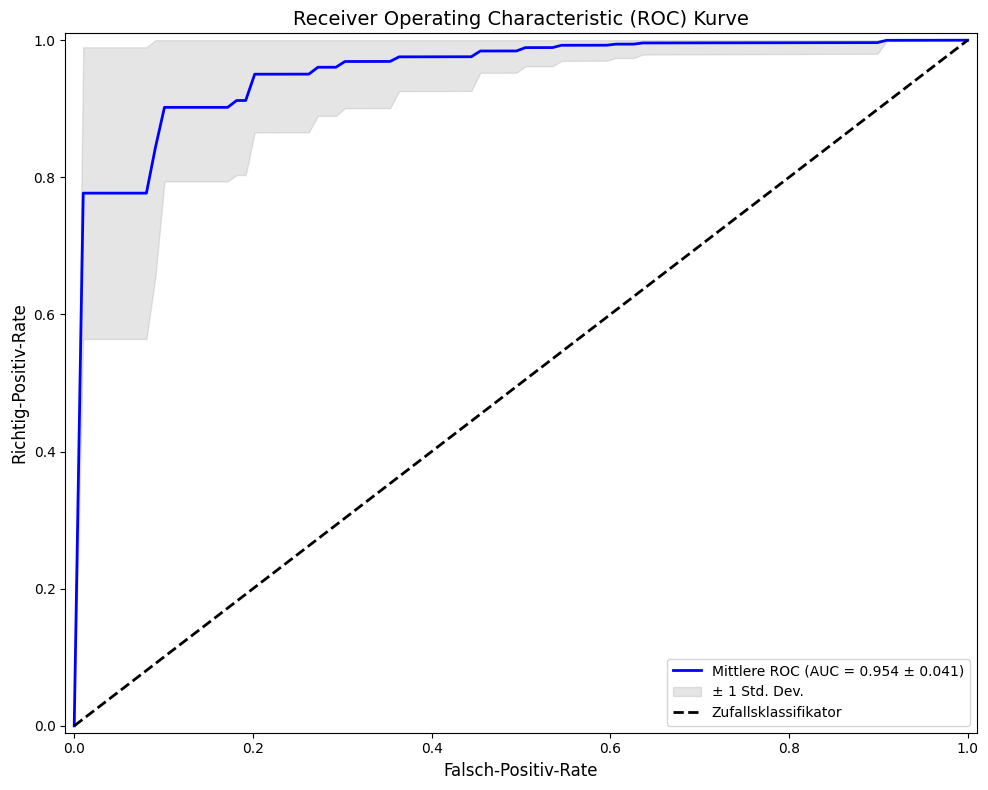


Mean AUC: 0.9540 ± 0.0411


In [ ]:
import os
# Umgebungsvariablen vor dem Import von TensorFlow setzen:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = alle Meldungen, 1 = Info, 2 = Warnungen, 3 = nur Fehler
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# =============================================================================
# ROC-AUC Kurve
# =============================================================================

def plot_roc_curves(cv_results, save_path=None):
    """
    Plottet nur die gemittelte ROC-Kurve mit Standardabweichung und Zufallslinie.
    
    Parameter:
    cv_results: Liste von Dictionaries mit 'y_true', 'y_pred_prob' für jeden Fold
    save_path: Pfad zum Speichern der Abbildung (optional)
    """
    plt.figure(figsize=(10, 8))
    
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    
    # Berechne ROC-Daten für jeden Fold (ohne zu plotten)
    for i, result in enumerate(cv_results):
        y_true = result['y_true']
        y_pred_prob = result['y_pred_prob']
        
        fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    # Plotte nur gemittelte ROC-Kurve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, 'b-', lw=2, 
             label=f'Mittlere ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})')
    
    # Plotte Standardabweichung
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                     label=f'± 1 Std. Dev.')
    
    # Plotte Zufallslinie
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Zufallsklassifikator')
    
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('Falsch-Positiv-Rate', fontsize=12)
    plt.ylabel('Richtig-Positiv-Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Kurve', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()
    
    return mean_auc, std_auc

# =============================================================================
# Augmentierungsfunktionen
# =============================================================================

def perform_clustering(X_sub, max_clusters=4):
    cols = [col for col in X_sub.columns if col not in ["Verletzungsstatus", "Geschlecht_weiblich"]]
    X_num = X_sub[cols]
    # Absolute Korrelationsmatrix, NA-Werte mit 0 auffüllen und Symmetrie erzwingen
    corr = X_num.corr().abs().fillna(0)
    corr = (corr + corr.T) / 2
    dist = np.clip(1 - corr, a_min=0, a_max=None)
    dists = squareform(dist.values)
    Z = linkage(dists, method='ward')
    cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')
    clusters = {}
    for col, label in zip(cols, cluster_labels):
        clusters.setdefault(label, []).append(col)
    return clusters

def augment_subgroup(X_sub, clusters, p_augment=0.7):
    augmented_rows = []
    cluster_params = {}
    for cl_id, cols in clusters.items():
        cluster_data = X_sub[cols]
        mu = cluster_data.mean().values
        if len(cols) == 1:
            cov = np.cov(cluster_data.values.flatten(), ddof=0)
            cov = np.atleast_2d(cov)
        else:
            cov = np.cov(cluster_data.values, rowvar=False)
        cluster_params[cl_id] = (mu, cov, cols)
    for idx, row in X_sub.iterrows():
        new_row = row.copy()
        for cl_id, (mu, cov, cols) in cluster_params.items():
            if np.random.rand() < p_augment:
                new_values = np.random.multivariate_normal(mu, cov)
                for col, val in zip(cols, new_values):
                    new_row[col] = val
        augmented_rows.append(new_row)
    augmented_df = pd.DataFrame(augmented_rows)
    # Binäre Spalten unverändert übernehmen
    for col in ["Geschlecht_weiblich", "Verletzungsstatus"]:
        if col in augmented_df.columns:
            augmented_df[col] = augmented_df[col].astype(int)
    return augmented_df

def process_group_cluster(group_df, num_new_samples, max_clusters, p_augment):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment)
        aug_list.append(aug)
    return pd.concat(aug_list, axis=0)

def augment_training_data_cluster(X_train, y_train, num_new_samples=1, max_clusters=4, p_augment=0.7, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = [group_df for _, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])]
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster)(group_df, num_new_samples, max_clusters, p_augment)
        for group_df in groups
    )
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def add_noise_to_data(df, noise_factor=0.1):
    df_noisy = df.copy()
    numeric_cols = [col for col in df_noisy.select_dtypes(include=['float64', 'int64']).columns 
                    if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    for col in numeric_cols:
        std = df_noisy[col].std()
        noise = np.random.normal(0, std * noise_factor, size=df_noisy.shape[0])
        df_noisy[col] += noise
    return df_noisy

def add_noise_to_group(df_group, noise_factor=0.1):
    return add_noise_to_data(df_group, noise_factor=noise_factor)

def process_group_cluster_noise(group_df, num_new_samples, max_clusters, p_augment, noise_factor):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment)
        aug_list.append(aug)
    aug_group = pd.concat(aug_list, axis=0).reset_index(drop=True)
    n = len(aug_group)
    half = n // 2
    global_noise = add_noise_to_data(aug_group.copy(), noise_factor=noise_factor)
    group_noise = add_noise_to_group(aug_group.copy(), noise_factor=noise_factor)
    aug_noisy = pd.concat([global_noise.iloc[:half], group_noise.iloc[:half]], axis=0)
    return aug_noisy

def augment_training_data_cluster_noise(X_train, y_train, num_new_samples=1, max_clusters=4, 
                                        p_augment=0.7, noise_factor=0.1, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = [group_df for _, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])]
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster_noise)(group_df, num_new_samples, max_clusters, p_augment, noise_factor)
        for group_df in groups
    )
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def process_group_means(group_df, group_new_samples):
    """Erzeugt neue Samples durch Mittelwertbildung aus zwei zufällig ausgewählten Samples.
       Dabei werden die binären Spalten 'Verletzungsstatus' und 'Geschlecht_weiblich' direkt übernommen."""
    group_df = group_df.reset_index(drop=True)
    new_group_samples = []
    if len(group_df) < 2:
        return None
    numeric_cols = [col for col in group_df.columns if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    pairs = np.random.choice(len(group_df), (group_new_samples, 2), replace=True)
    for i in range(group_new_samples):
        sample1 = group_df.iloc[pairs[i, 0]]
        sample2 = group_df.iloc[pairs[i, 1]]
        mean_sample = sample1.copy()
        for col in numeric_cols:
            mean_sample[col] = (sample1[col] + sample2[col]) / 2
        mean_sample["Verletzungsstatus"] = sample1["Verletzungsstatus"]
        mean_sample["Geschlecht_weiblich"] = sample1["Geschlecht_weiblich"]
        new_group_samples.append(mean_sample)
    if new_group_samples:
        return pd.DataFrame(new_group_samples)
    return None

def augment_data_by_group_means(X_train, y_train, augmentation_factor=2, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])
    total_original_samples = len(df_train)
    total_new_samples = int(total_original_samples * (augmentation_factor - 1))
    group_sizes = groups.size()
    group_proportions = group_sizes / total_original_samples
    tasks = []
    for (injury_status, is_female), group_df in groups:
        group_new_samples = int(total_new_samples * group_proportions[(injury_status, is_female)])
        tasks.append((group_df, group_new_samples))
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_means)(group_df, group_new_samples)
        for group_df, group_new_samples in tasks
    )
    augmented_groups = [group for group in augmented_groups if group is not None]
    augmented_df = pd.concat([df_train] + augmented_groups, ignore_index=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def augment_training_data_combined(X_train, y_train, target_size=1000, verbose=True, n_jobs=-1,
                                   max_clusters=4, noise_factor=0.1):
    """
    Führt alle drei Augmentierungsmethoden (Cluster-basiert, Cluster+Rauschen, Mittelwert-basiert)
    parallel aus und kombiniert die Ergebnisse, um den Trainingsdatensatz auf die gewünschte Zielgröße zu bringen.
    """
    start_time = time.time()
    N = len(X_train)
    additional_needed = max(target_size - N, 0)
    per_method_needed = additional_needed // 3
    num_new_samples = max(per_method_needed // N, 1)
    augmentation_factor = 1 + (per_method_needed / N)
    if verbose:
        print(f"Starting combined augmentation to reach target size: {target_size}")
        print(f"Original dataset size: {N}")
        print(f"Samples needed per method: {per_method_needed}")
    funcs_and_params = [
        (augment_training_data_cluster, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
        (augment_training_data_cluster_noise, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
        (augment_data_by_group_means, {"augmentation_factor": augmentation_factor, "n_jobs": n_jobs})
    ]
    results = Parallel(n_jobs=min(3, n_jobs))(
        delayed(func)(X_train, y_train, **params) for func, params in funcs_and_params
    )
    X_aug_cluster, y_aug_cluster = results[0]
    X_aug_cluster_noise, y_aug_cluster_noise = results[1]
    X_aug_group_means, y_aug_group_means = results[2]
    def subsample(X_aug, y_aug, required):
        if len(X_aug) > required:
            idx = np.random.choice(len(X_aug), required, replace=False)
            return X_aug.iloc[idx].reset_index(drop=True), y_aug.iloc[idx].reset_index(drop=True)
        else:
            return X_aug, y_aug
    X_aug_cluster, y_aug_cluster = subsample(X_aug_cluster, y_aug_cluster, per_method_needed)
    X_aug_cluster_noise, y_aug_cluster_noise = subsample(X_aug_cluster_noise, y_aug_cluster_noise, per_method_needed)
    X_aug_group_means, y_aug_group_means = subsample(X_aug_group_means, y_aug_group_means, per_method_needed)
    X_aug_combined = pd.concat([X_aug_cluster, X_aug_cluster_noise, X_aug_group_means], axis=0).reset_index(drop=True)
    y_aug_combined = pd.concat([y_aug_cluster, y_aug_cluster_noise, y_aug_group_means], axis=0).reset_index(drop=True)
    X_total = pd.concat([X_train.reset_index(drop=True), X_aug_combined], axis=0).reset_index(drop=True)
    y_total = pd.concat([y_train.reset_index(drop=True), y_aug_combined], axis=0).reset_index(drop=True)
    if len(X_total) > target_size:
        idx = np.random.choice(len(X_total), target_size, replace=False)
        X_total = X_total.iloc[idx].reset_index(drop=True)
        y_total = y_total.iloc[idx].reset_index(drop=True)
    elapsed_time = time.time() - start_time
    if verbose:
        print(f"Augmentation completed. Final dataset size: {len(X_total)}")
        print(f"Augmentation took {elapsed_time:.2f} seconds")
    return X_total, y_total

# =============================================================================
# Modellaufbau und Training
# =============================================================================

def create_model(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# =============================================================================
# CV-Pipeline
# =============================================================================


def run_cv_pipeline(data_path, target_column="Verletzungsstatus", cv_splits=5, cv_repeats=10,
                    target_augmentation_multiplier=11, verbose=True, n_jobs=-1):
    """
    Liest die Daten ein, führt eine stratified Cross-Validation durch, 
    augmentiert in jedem Fold den Trainingsdatensatz und trainiert anschließend ein Modell.
    Aggregiert die Ergebnisse (Mittelwert und Standardabweichung) und gibt diese zurück.
    """
    try:
        df = pd.read_excel(data_path)
    except Exception as e:
        print(f"Error loading data: {e}")
        return None
    if target_column not in df.columns:
        print(f"Target column '{target_column}' not found in data")
        return None
    y = df[target_column]
    X = df.drop(columns=[target_column])
    if verbose:
        print(f"Data loaded: {len(df)} samples, {X.shape[1]} features")
        print(f"Class distribution: {y.value_counts().to_dict()}")
    cv = RepeatedStratifiedKFold(n_splits=cv_splits, n_repeats=cv_repeats, random_state=42)
    metrics_results = []
    roc_data = []  # Liste für ROC-Daten
    for train_index, test_index in cv.split(X, y):
        if verbose:
            print("\n--- New Fold ---")
        X_train, y_train = X.iloc[train_index].copy(), y.iloc[train_index].copy()
        X_test, y_test = X.iloc[test_index].copy(), y.iloc[test_index].copy()
        target_size = int(len(X_train) * target_augmentation_multiplier)
        # Augmentation durchführen
        X_train_aug, y_train_aug = augment_training_data_combined(X_train, y_train,
                                                                   target_size=target_size,
                                                                   verbose=verbose,
                                                                   n_jobs=n_jobs)
        # Skalierung
        scaler = MinMaxScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_aug), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
        # Modell erstellen und trainieren
        model = create_model(input_dim=X_train_scaled.shape[1])
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = model.fit(X_train_scaled, y_train_aug,
                            validation_split=0.2,
                            epochs=100,
                            batch_size=16,
                            callbacks=[early_stop],
                            verbose=0)
        # Evaluation auf Trainingsdaten (Train Accuracy)
        y_train_pred_prob = model.predict(X_train_scaled, verbose=0)
        y_train_pred = (y_train_pred_prob > 0.5).astype(int).flatten()
        train_acc = accuracy_score(y_train_aug, y_train_pred)
        # Evaluation auf Testdaten (Test Accuracy und weitere Metriken)
        y_pred_prob = model.predict(X_test_scaled, verbose=0)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
        test_acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        # ROC-Daten speichern
        roc_data.append({
            'y_true': y_test.values,
            'y_pred_prob': y_pred_prob.flatten()
        })

        try:
            roc = roc_auc_score(y_test, y_pred_prob)
        except Exception:
            roc = None
        metrics_results.append({
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'f1_score': f1,
            'precision': prec,
            'recall': rec,
            'roc_auc': roc
        })
    results_df = pd.DataFrame(metrics_results)
    mean_metrics = results_df.mean(numeric_only=True)
    std_metrics = results_df.std(numeric_only=True)
    aggregated = {"mean": mean_metrics.to_dict(), "std": std_metrics.to_dict()}
    return aggregated, roc_data

def main():
    data_path = r"C:\Users\boehmer\JupyterProjects\neuronales_netz_motum\data\Basistabelle_ML_neu.xlsx"
    aggregated_results, roc_data = run_cv_pipeline(data_path, cv_splits=5, cv_repeats=10,
                                         target_augmentation_multiplier=11, verbose=False, n_jobs=-1)
    if aggregated_results is None:
        print("Pipeline failed.")
        return

    print("\n=== Model Performance Summary ===")
    print("{:<15} {:<20} {:<20}".format("Metric", "Mean", "Std"))
    for metric, mean_val in aggregated_results["mean"].items():
        std_val = aggregated_results["std"].get(metric, np.nan)
        print("{:<15} {:<20.4f} {:<20.4f}".format(metric, mean_val, std_val))
    
    # ROC-Kurven plotten
    mean_auc, std_auc = plot_roc_curves(roc_data, save_path=r"C:\Users\boehmer\JupyterProjects\neuronales_netz_motum\data\roc_curve_results.png")
    print(f"\nMean AUC: {mean_auc:.4f} ± {std_auc:.4f}")

if __name__ == "__main__":
    main()





### Optimierungsansatz 1

In [ ]:
import os
# Umgebungsvariablen vor dem Import von TensorFlow setzen:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = alle Meldungen, 1 = Info, 2 = Warnungen, 3 = nur Fehler
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# =============================================================================
# Augmentierungsfunktionen
# =============================================================================

def perform_clustering(X_sub, max_clusters=4):
    cols = [col for col in X_sub.columns if col not in ["Verletzungsstatus", "Geschlecht_weiblich"]]
    X_num = X_sub[cols]
    # Absolute Korrelationsmatrix, NA-Werte mit 0 auffüllen und Symmetrie erzwingen
    corr = X_num.corr().abs().fillna(0)
    corr = (corr + corr.T) / 2
    dist = np.clip(1 - corr, a_min=0, a_max=None)
    dists = squareform(dist.values)
    Z = linkage(dists, method='ward')
    cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')
    clusters = {}
    for col, label in zip(cols, cluster_labels):
        clusters.setdefault(label, []).append(col)
    return clusters

def augment_subgroup(X_sub, clusters, p_augment=0.7):
    augmented_rows = []
    cluster_params = {}
    for cl_id, cols in clusters.items():
        cluster_data = X_sub[cols]
        mu = cluster_data.mean().values
        if len(cols) == 1:
            cov = np.cov(cluster_data.values.flatten(), ddof=0)
            cov = np.atleast_2d(cov)
        else:
            cov = np.cov(cluster_data.values, rowvar=False)
        cluster_params[cl_id] = (mu, cov, cols)
    for idx, row in X_sub.iterrows():
        new_row = row.copy()
        for cl_id, (mu, cov, cols) in cluster_params.items():
            if np.random.rand() < p_augment:
                new_values = np.random.multivariate_normal(mu, cov)
                for col, val in zip(cols, new_values):
                    new_row[col] = val
        augmented_rows.append(new_row)
    augmented_df = pd.DataFrame(augmented_rows)
    # Binäre Spalten unverändert übernehmen
    for col in ["Geschlecht_weiblich", "Verletzungsstatus"]:
        if col in augmented_df.columns:
            augmented_df[col] = augmented_df[col].astype(int)
    return augmented_df

def process_group_cluster(group_df, num_new_samples, max_clusters, p_augment):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment)
        aug_list.append(aug)
    return pd.concat(aug_list, axis=0)

def augment_training_data_cluster(X_train, y_train, num_new_samples=1, max_clusters=4, p_augment=0.7, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = [group_df for _, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])]
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster)(group_df, num_new_samples, max_clusters, p_augment)
        for group_df in groups
    )
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def add_noise_to_data(df, noise_factor=0.1):
    df_noisy = df.copy()
    numeric_cols = [col for col in df_noisy.select_dtypes(include=['float64', 'int64']).columns 
                    if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    for col in numeric_cols:
        std = df_noisy[col].std()
        noise = np.random.normal(0, std * noise_factor, size=df_noisy.shape[0])
        df_noisy[col] += noise
    return df_noisy

def add_noise_to_group(df_group, noise_factor=0.1):
    return add_noise_to_data(df_group, noise_factor=noise_factor)

def process_group_cluster_noise(group_df, num_new_samples, max_clusters, p_augment, noise_factor):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment)
        aug_list.append(aug)
    aug_group = pd.concat(aug_list, axis=0).reset_index(drop=True)
    n = len(aug_group)
    half = n // 2
    global_noise = add_noise_to_data(aug_group.copy(), noise_factor=noise_factor)
    group_noise = add_noise_to_group(aug_group.copy(), noise_factor=noise_factor)
    aug_noisy = pd.concat([global_noise.iloc[:half], group_noise.iloc[:half]], axis=0)
    return aug_noisy

def augment_training_data_cluster_noise(X_train, y_train, num_new_samples=1, max_clusters=4, 
                                        p_augment=0.7, noise_factor=0.1, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = [group_df for _, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])]
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster_noise)(group_df, num_new_samples, max_clusters, p_augment, noise_factor)
        for group_df in groups
    )
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def process_group_means(group_df, group_new_samples):
    """Erzeugt neue Samples durch Mittelwertbildung aus zwei zufällig ausgewählten Samples.
       Dabei werden die binären Spalten 'Verletzungsstatus' und 'Geschlecht_weiblich' direkt übernommen."""
    group_df = group_df.reset_index(drop=True)
    new_group_samples = []
    if len(group_df) < 2:
        return None
    numeric_cols = [col for col in group_df.columns if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    pairs = np.random.choice(len(group_df), (group_new_samples, 2), replace=True)
    for i in range(group_new_samples):
        sample1 = group_df.iloc[pairs[i, 0]]
        sample2 = group_df.iloc[pairs[i, 1]]
        mean_sample = sample1.copy()
        for col in numeric_cols:
            mean_sample[col] = (sample1[col] + sample2[col]) / 2
        mean_sample["Verletzungsstatus"] = sample1["Verletzungsstatus"]
        mean_sample["Geschlecht_weiblich"] = sample1["Geschlecht_weiblich"]
        new_group_samples.append(mean_sample)
    if new_group_samples:
        return pd.DataFrame(new_group_samples)
    return None

def augment_data_by_group_means(X_train, y_train, augmentation_factor=2, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])
    total_original_samples = len(df_train)
    total_new_samples = int(total_original_samples * (augmentation_factor - 1))
    group_sizes = groups.size()
    group_proportions = group_sizes / total_original_samples
    tasks = []
    for (injury_status, is_female), group_df in groups:
        group_new_samples = int(total_new_samples * group_proportions[(injury_status, is_female)])
        tasks.append((group_df, group_new_samples))
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_means)(group_df, group_new_samples)
        for group_df, group_new_samples in tasks
    )
    augmented_groups = [group for group in augmented_groups if group is not None]
    augmented_df = pd.concat([df_train] + augmented_groups, ignore_index=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def augment_training_data_combined(X_train, y_train, target_size=1000, verbose=True, n_jobs=-1,
                                   max_clusters=4, noise_factor=0.1):
    """
    Führt alle drei Augmentierungsmethoden (Cluster-basiert, Cluster+Rauschen, Mittelwert-basiert)
    parallel aus und kombiniert die Ergebnisse, um den Trainingsdatensatz auf die gewünschte Zielgröße zu bringen.
    """
    start_time = time.time()
    N = len(X_train)
    additional_needed = max(target_size - N, 0)
    per_method_needed = additional_needed // 3
    num_new_samples = max(per_method_needed // N, 1)
    augmentation_factor = 1 + (per_method_needed / N)
    if verbose:
        print(f"Starting combined augmentation to reach target size: {target_size}")
        print(f"Original dataset size: {N}")
        print(f"Samples needed per method: {per_method_needed}")
    funcs_and_params = [
        (augment_training_data_cluster, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
        (augment_training_data_cluster_noise, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
        (augment_data_by_group_means, {"augmentation_factor": augmentation_factor, "n_jobs": n_jobs})
    ]
    results = Parallel(n_jobs=min(3, n_jobs))(
        delayed(func)(X_train, y_train, **params) for func, params in funcs_and_params
    )
    X_aug_cluster, y_aug_cluster = results[0]
    X_aug_cluster_noise, y_aug_cluster_noise = results[1]
    X_aug_group_means, y_aug_group_means = results[2]
    def subsample(X_aug, y_aug, required):
        if len(X_aug) > required:
            idx = np.random.choice(len(X_aug), required, replace=False)
            return X_aug.iloc[idx].reset_index(drop=True), y_aug.iloc[idx].reset_index(drop=True)
        else:
            return X_aug, y_aug
    X_aug_cluster, y_aug_cluster = subsample(X_aug_cluster, y_aug_cluster, per_method_needed)
    X_aug_cluster_noise, y_aug_cluster_noise = subsample(X_aug_cluster_noise, y_aug_cluster_noise, per_method_needed)
    X_aug_group_means, y_aug_group_means = subsample(X_aug_group_means, y_aug_group_means, per_method_needed)
    X_aug_combined = pd.concat([X_aug_cluster, X_aug_cluster_noise, X_aug_group_means], axis=0).reset_index(drop=True)
    y_aug_combined = pd.concat([y_aug_cluster, y_aug_cluster_noise, y_aug_group_means], axis=0).reset_index(drop=True)
    X_total = pd.concat([X_train.reset_index(drop=True), X_aug_combined], axis=0).reset_index(drop=True)
    y_total = pd.concat([y_train.reset_index(drop=True), y_aug_combined], axis=0).reset_index(drop=True)
    if len(X_total) > target_size:
        idx = np.random.choice(len(X_total), target_size, replace=False)
        X_total = X_total.iloc[idx].reset_index(drop=True)
        y_total = y_total.iloc[idx].reset_index(drop=True)
    elapsed_time = time.time() - start_time
    if verbose:
        print(f"Augmentation completed. Final dataset size: {len(X_total)}")
        print(f"Augmentation took {elapsed_time:.2f} seconds")
    return X_total, y_total

# =============================================================================
# Modellaufbau und Training
# =============================================================================

def create_model(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# =============================================================================
# CV-Pipeline
# =============================================================================


def run_cv_pipeline(data_path, target_column="Verletzungsstatus", cv_splits=5, cv_repeats=10,
                    target_augmentation_multiplier=11, verbose=True, n_jobs=-1):
    """
    Liest die Daten ein, führt eine stratified Cross-Validation durch, 
    augmentiert in jedem Fold den Trainingsdatensatz und trainiert anschließend ein Modell.
    Aggregiert die Ergebnisse (Mittelwert und Standardabweichung) und gibt diese zurück.
    """
    try:
        df = pd.read_excel(data_path)
    except Exception as e:
        print(f"Error loading data: {e}")
        return None
    if target_column not in df.columns:
        print(f"Target column '{target_column}' not found in data")
        return None
    y = df[target_column]
    X = df.drop(columns=[target_column])
    if verbose:
        print(f"Data loaded: {len(df)} samples, {X.shape[1]} features")
        print(f"Class distribution: {y.value_counts().to_dict()}")
    cv = RepeatedStratifiedKFold(n_splits=cv_splits, n_repeats=cv_repeats, random_state=42)
    metrics_results = []
   
    for train_index, test_index in cv.split(X, y):
        if verbose:
            print("\n--- New Fold ---")
        X_train, y_train = X.iloc[train_index].copy(), y.iloc[train_index].copy()
        X_test, y_test = X.iloc[test_index].copy(), y.iloc[test_index].copy()
        target_size = int(len(X_train) * target_augmentation_multiplier)
        # Augmentation durchführen
        X_train_aug, y_train_aug = augment_training_data_combined(X_train, y_train,
                                                                   target_size=target_size,
                                                                   verbose=verbose,
                                                                   n_jobs=n_jobs)
        # Skalierung
        scaler = MinMaxScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_aug), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
        # Modell erstellen und trainieren
        model = create_model(input_dim=X_train_scaled.shape[1])
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = model.fit(X_train_scaled, y_train_aug,
                            validation_split=0.2,
                            epochs=100,
                            batch_size=16,
                            callbacks=[early_stop],
                            verbose=0)
        # Evaluation auf Trainingsdaten (Train Accuracy)
        y_train_pred_prob = model.predict(X_train_scaled, verbose=0)
        y_train_pred = (y_train_pred_prob > 0.5).astype(int).flatten()
        train_acc = accuracy_score(y_train_aug, y_train_pred)
        # Evaluation auf Testdaten (Test Accuracy und weitere Metriken)
        y_pred_prob = model.predict(X_test_scaled, verbose=0)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
        test_acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)

        try:
            roc = roc_auc_score(y_test, y_pred_prob)
        except Exception:
            roc = None
        metrics_results.append({
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'f1_score': f1,
            'precision': prec,
            'recall': rec,
            'roc_auc': roc
        })
    results_df = pd.DataFrame(metrics_results)
    mean_metrics = results_df.mean(numeric_only=True)
    std_metrics = results_df.std(numeric_only=True)
    aggregated = {"mean": mean_metrics.to_dict(), "std": std_metrics.to_dict()}
    return aggregated

def main():
    data_path = r"C:\Users\boehmer\JupyterProjects\neuronales_netz_motum\data\Basistabelle_ML_neu.xlsx"
    aggregated_results, roc_data = run_cv_pipeline(data_path, cv_splits=5, cv_repeats=10,
                                         target_augmentation_multiplier=11, verbose=False, n_jobs=-1)
    if aggregated_results is None:
        print("Pipeline failed.")
        return

    print("\n=== Model Performance Summary ===")
    print("{:<15} {:<20} {:<20}".format("Metric", "Mean", "Std"))
    for metric, mean_val in aggregated_results["mean"].items():
        std_val = aggregated_results["std"].get(metric, np.nan)
        print("{:<15} {:<20.4f} {:<20.4f}".format(metric, mean_val, std_val))
    

if __name__ == "__main__":
    main()

